<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_m1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock

fatal: destination path 'AE-w.-Bottleneck-Residual-Blocks' already exists and is not an empty directory.
/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 128

initializer = initializers.HeNormal(seed=123)

# **Loading the dataset**

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

# **Defining the model**

In [5]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 bridge_residual_conv2d_blo  (None, 14, 14, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                           

In [6]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 2, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 2, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 2, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 2, initializer)(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 2, initializer)(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 2, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 re_lu_26 (ReLU)             (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 768)               393984    
                                                                 
 re_lu_27 (ReLU)             (None, 768)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              787456    
                                                                 
 re_lu_28 (ReLU)             (None, 1024)              0   

In [7]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               13847104  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         12409859  
                                                                 
Total params: 26256963 (100.16 MB)
Trainable params: 26236995 (100.09 MB)
Non-trainable params: 19968 (78.00 KB)
_________________________________________________________________


# **Training**

In [8]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=10)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, callbacks=[callback])

Epoch 1/80
391/391 [==============================] - 85s 123ms/step - loss: 0.0393 - accuracy: 0.4447 - val_loss: 0.0325 - val_accuracy: 0.4678
Epoch 2/80
391/391 [==============================] - 42s 107ms/step - loss: 0.0263 - accuracy: 0.4677 - val_loss: 0.0266 - val_accuracy: 0.4725
Epoch 3/80
391/391 [==============================] - 42s 107ms/step - loss: 0.0232 - accuracy: 0.4937 - val_loss: 0.0231 - val_accuracy: 0.5034
Epoch 4/80
391/391 [==============================] - 42s 107ms/step - loss: 0.0203 - accuracy: 0.5495 - val_loss: 0.0206 - val_accuracy: 0.5669
Epoch 5/80
391/391 [==============================] - 42s 106ms/step - loss: 0.0185 - accuracy: 0.5767 - val_loss: 0.0193 - val_accuracy: 0.5732
Epoch 6/80
391/391 [==============================] - 41s 106ms/step - loss: 0.0171 - accuracy: 0.5903 - val_loss: 0.0177 - val_accuracy: 0.6063
Epoch 7/80
391/391 [==============================] - 42s 107ms/step - loss: 0.0163 - accuracy: 0.6027 - val_loss: 0.0177 - val_ac

In [9]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = 0.00005)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 70s 112ms/step - loss: 0.0076 - accuracy: 0.7321 - val_loss: 0.0087 - val_accuracy: 0.7293
Epoch 2/30
391/391 [==============================] - 41s 106ms/step - loss: 0.0076 - accuracy: 0.7319 - val_loss: 0.0085 - val_accuracy: 0.7314
Epoch 3/30
391/391 [==============================] - 42s 107ms/step - loss: 0.0076 - accuracy: 0.7322 - val_loss: 0.0086 - val_accuracy: 0.7322
Epoch 4/30
391/391 [==============================] - 41s 106ms/step - loss: 0.0075 - accuracy: 0.7330 - val_loss: 0.0090 - val_accuracy: 0.7168
Epoch 5/30
391/391 [==============================] - 42s 106ms/step - loss: 0.0075 - accuracy: 0.7331 - val_loss: 0.0091 - val_accuracy: 0.7288
Epoch 6/30
391/391 [==============================] - 42s 106ms/step - loss: 0.0075 - accuracy: 0.7331 - val_loss: 0.0088 - val_accuracy: 0.7048
Epoch 7/30
391/391 [==============================] - 42s 106ms/step - loss: 0.0075 - accuracy: 0.7331 - val_loss: 0.0096 - val_ac

In [10]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=40, callbacks=[callback])

Epoch 1/40
391/391 [==============================] - 71s 112ms/step - loss: 0.0070 - accuracy: 0.7396 - val_loss: 0.0080 - val_accuracy: 0.7361
Epoch 2/40
391/391 [==============================] - 41s 106ms/step - loss: 0.0070 - accuracy: 0.7402 - val_loss: 0.0080 - val_accuracy: 0.7394
Epoch 3/40
391/391 [==============================] - 42s 106ms/step - loss: 0.0069 - accuracy: 0.7408 - val_loss: 0.0079 - val_accuracy: 0.7363
Epoch 4/40
391/391 [==============================] - 41s 106ms/step - loss: 0.0069 - accuracy: 0.7413 - val_loss: 0.0079 - val_accuracy: 0.7338
Epoch 5/40
391/391 [==============================] - 41s 106ms/step - loss: 0.0069 - accuracy: 0.7408 - val_loss: 0.0081 - val_accuracy: 0.7365
Epoch 6/40
391/391 [==============================] - 41s 106ms/step - loss: 0.0069 - accuracy: 0.7405 - val_loss: 0.0080 - val_accuracy: 0.7349
Epoch 7/40
391/391 [==============================] - 42s 106ms/step - loss: 0.0069 - accuracy: 0.7413 - val_loss: 0.0080 - val_ac

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.000005, decay_steps=782, decay_rate=0.9)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = lr_schedule)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history4 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, callbacks=[callback])

Epoch 1/30
391/391 [==============================] - 80s 109ms/step - loss: 0.0067 - accuracy: 0.7418 - val_loss: 0.0080 - val_accuracy: 0.7383
Epoch 2/30
391/391 [==============================] - 42s 107ms/step - loss: 0.0067 - accuracy: 0.7418 - val_loss: 0.0080 - val_accuracy: 0.7365
Epoch 3/30
391/391 [==============================] - 41s 106ms/step - loss: 0.0067 - accuracy: 0.7412 - val_loss: 0.0080 - val_accuracy: 0.7401
Epoch 4/30
391/391 [==============================] - 41s 106ms/step - loss: 0.0067 - accuracy: 0.7424 - val_loss: 0.0080 - val_accuracy: 0.7381
Epoch 5/30
391/391 [==============================] - 41s 106ms/step - loss: 0.0067 - accuracy: 0.7415 - val_loss: 0.0080 - val_accuracy: 0.7384
Epoch 6/30
391/391 [==============================] - 41s 106ms/step - loss: 0.0067 - accuracy: 0.7419 - val_loss: 0.0080 - val_accuracy: 0.7375
Epoch 7/30
391/391 [==============================] - 41s 106ms/step - loss: 0.0067 - accuracy: 0.7422 - val_loss: 0.0079 - val_ac

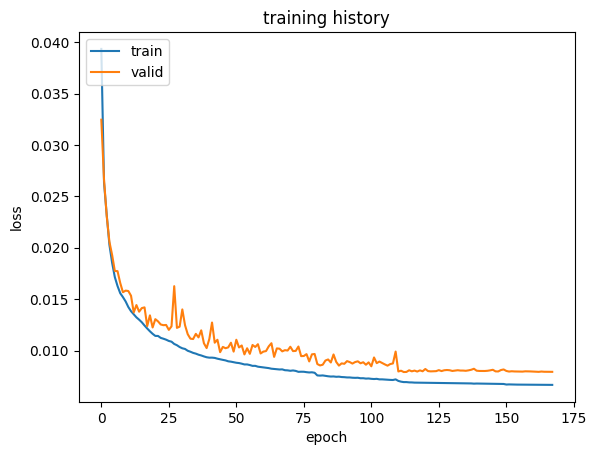

In [13]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

# **Reconstructions**

In [14]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

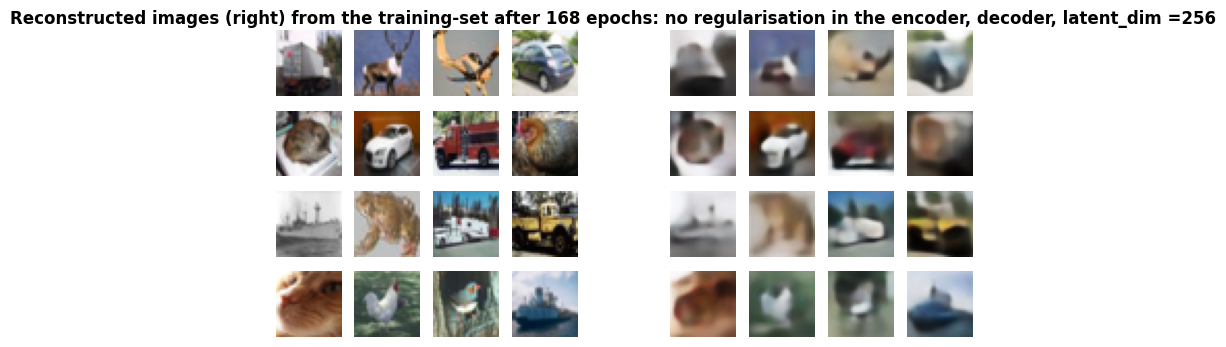

In [16]:
plot_reconstruction(img_train, 'training', 123, 168)

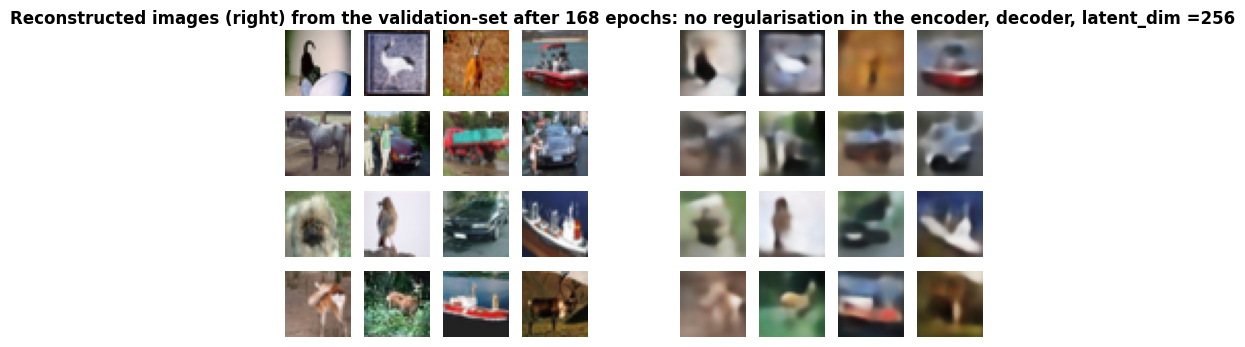

In [17]:
plot_reconstruction(img_valid, 'validation', 123, 168)

The accuracy obtained is around 74%, but qualitatively the reconstructions are sometimes worse (and sometimes better) than in model 2 where the accuracy is around 72%